Welcome to the example docs for diff_classifier.  This example will walk you through using diff_classifier to track particle trajectories from a video collected via fluorescence microscopy, or some other imaging technique.  

# Loading and checking video

In order to properly track the video, the user must enter the following relevant information regarding the video to be tracked:
* **prefix**: the name of the file to be tracked, minus the file extension.  Typically tif files are the best to track.
* **local_folder**: the location of the video to be tracked.
* **ires**: the desired resolution of sub-videos to be tracked.  Since the images to be tracked may be too large to analyze all at once, the user may need to crop images to perform correctly.  512 x 512 pixels is the standard size.
* **frames**: number of frames contained in the video.  

In [1]:
import os.path as op
from diff_classifier import aws as aws

In [2]:
prefix = '100nm_PEG_90p_XY1'
local_folder = '.'
rfolder = '06_11_18_glycerol_validation'
aws.download_s3('{}/{}.tif'.format(rfolder, prefix), '{}/{}.tif'.format(local_folder, prefix), bucket_name = 'hpontes.data')

ires = 512
frames = 651

In [3]:
import skimage.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
local_name = '{}.tif'.format(prefix)
example = sio.imread(local_name)

(-0.5, 2047.5, 2043.5, -0.5)

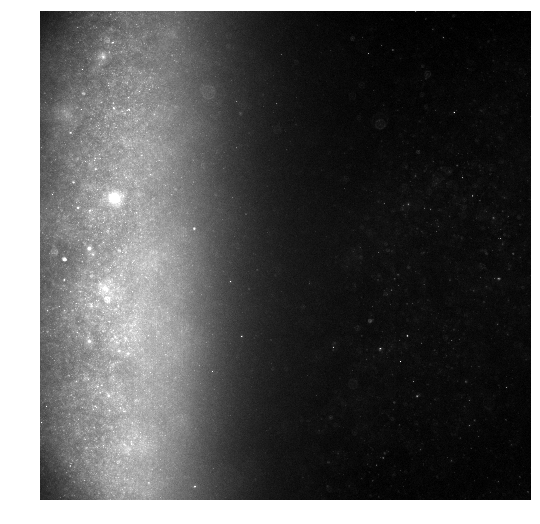

In [5]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(example[20, :, :], cmap='gray', vmin=20, vmax=60000)
ax.axis('off')

# Splitting images prior to analysis

There is an upper limit on image resolution depending on the available RAM on your machine.  I typically limit analyses to images less than 1024 x 1024 pixels, and usually use 512 x 512 pixel images to be consistent.  The large images from the microscope in our lab are 2048 x 2044, resulting in 16 512 x 512 images, with a black band of 0s of the bottom 4 images.

In [6]:
import diff_classifier.imagej as ij

names = ij.partition_im(local_name)
for name in names:
    aws.upload_s3(name, op.join(rfolder, name), bucket_name='hpontes.data')
    print("Done with splitting.  Should output file of name {}".format(local_folder+'/'+name))

Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_0_0.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_0_1.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_0_2.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_0_3.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_1_0.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_1_1.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_1_2.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_1_3.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_2_0.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_2_1.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_2_2.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_2_3.tif
Done with splitting.  Should output file of name ./100nm_PEG_90p_XY1_3_0.tif

In [7]:
names = []
for i in range(0, 4):
    for j in range(0, 4):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))

# Particle tracking

Particle tracking is performed with a Trackmate script as exemplified [here](https://imagej.net/Scripting_TrackMate).  The function track allows the user to select relevant tracking parameters.  Current iteration of the code limits tracking to the DoG detector and the Sparse LAP tracker.  The following tracking parameters must be specified for tracking:
* **template**: location of template file containing Trackmate script. Default Trackmate script is used if set to None.
* **fiji_bin**: location of Fiji bin.  Fiji is required for tracking.

* **radius**: estimated particle radius in pixels. Can take half values.
* **threshold**: detection cutoff.  Default is 0.
* **do_median_filtering**: if set to True, will perform a median filter before tracking.
* **quality**: quality cutoff level.
* **x**: Upper x coordinate threshold.  If used, will exclude spots that have x coordinate greater than specified value.
* **y**: Upper y coordinate threshold.
* **ylo**: Lower y coordinate threshold.
* **median_intensity**: currently not used.
* **snr**: Signal-to-noise ratio cutoff.  Default is 0.
* **linking_max_distance**: max distance in pixels a particle can travel in a single frame.
* **gap_closing_max_distance**: max distance in pixels a particle can travel and be picked up by detector when a frame is skipped.
* **max_frame_gap**: number of frames a particle can disappear and still be linked.
* **track_displacement**: lower duration cutoff in frames. Tracks must be this many frames long to be included in final dataset.

Quality is the trickiest parameter to select, and can make or break a successful tracking iteration.  The key benefit to this software package is the ability to track large numbers of files at once.  If your files are similar enough, you can get away with using a single quality value for all videos.  In this case, I used two quality values depending on the mean intensity of the input image, which I found correlated with the best quality values for the tracking settings. In another notebook, I use a training dataset to predict quality based on the input mean intensity of the image to be tracked.

In [8]:
for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = op.join(local_folder, name)
    
    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

#     try:
#         aws.download_s3(remote_folder+'/'+outfile, outfile)
#     except:
    test_intensity = ij.mean_intensity(local_im)
    quality = 230
        
    if row==3:
        y = 485
    else:
        y = 511

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.0, threshold=0., 
          do_median_filtering=False, quality=quality, x=511, y=y, ylo=1, median_intensity=300.0, snr=0.0, 
          linking_max_distance=4.0, gap_closing_max_distance=7.0, max_frame_gap=2,
          track_displacement=20.0)

    print("Done with tracking.  Should output file of name {}".format(local_folder+'/'+outfile))

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpy5hdjd1b.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_0_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpag1btkf6.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_0_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmppju8bww8.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_0_2.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmph4do0dey.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_0_3.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp9qup8_7w.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_1_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpd1h8wt63.py
Done with tracking.  Should output file of name ./Traj_100nm_PEG_90p_XY1_1_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux

In [9]:
int(name.split('.')[0].split('_')[4])

3

# Calculating MSDs and features

This package uses pandas dataframes to perform MSD and feature calculations.  The first dataframe contains the xy coordinates and the MSDs of each trajectory at each frame.  The second dataframe contains a single row for each trajectory and associated features of each trajectory.

This bit of code also only creates a single dataframe for each original input video, rather than creating one for each sub-video after splitting up the images.  They're a lot easier to keep track of that way and minimized total files created.

In [10]:
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft

msd_file = 'msd_{}.csv'.format(prefix)
ft_file = 'features_{}.csv'.format(prefix)

counter = 0
for name in names:
    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

    filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
    local_name = filename

    if counter == 0:
        to_add = ut.csv_to_pd(local_name)
        to_add['X'] = to_add['X'] + ires*col
        to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
        merged = msd.all_msds2(to_add, frames=frames)
    else: 

        if merged.shape[0] > 0:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
        else:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            to_add['Track_ID'] = to_add['Track_ID']

        merged = merged.append(msd.all_msds2(to_add, frames=frames))
        print('Done calculating MSDs for row {} and col {}'.format(row, col))
    counter = counter + 1

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3


In [11]:
merged.to_csv(msd_file)
aws.upload_s3(msd_file, rfolder+'/'+msd_file, bucket_name='hpontes.data')
merged_ft = ft.calculate_features(merged)
merged_ft.to_csv(ft_file)
aws.upload_s3(ft_file, rfolder+'/'+ft_file, bucket_name='hpontes.data')

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  ar = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:671: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (df['MSDs'][n1]/df['MSDs'][n2]) - (df['Frame'][n1]/df['Frame'][n2])


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:293: RuntimeWarning: invalid value encountered in double_scalars
  a1 = (l1**2 - l2**2)**2/(l1**2 + l2**2)**2
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:294: RuntimeWarning: invalid value encountered in double_scalars
  a2 = l2/l1
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:295: RuntimeWarning: invalid value encountered in double_scalars
  a3 = -np.log(1-((l1-l2)**2)/(2*(l1+l2)**2))
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:478: RuntimeWarning: invalid value encountered in double_scalars
  ar = width/height
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:560: RuntimeWarning: invalid value encountered in double_scalars
  B = D*f/(r**2)
/home/ubuntu/source/diff-classifier/diff_classifier/features.py:561: RuntimeWarning: invalid value encountered in double_scalars
  Df = np.log(N)/np.log(N*2*r/L)
/home/ubuntu/source/diff-classifier/diff_classifier/

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

In [12]:
merged.head()

,Frame,Gauss,MSDs,Track_ID,X,Y
0,0.0,0.000000,0.000000,0.0,353.170512,1562.010874
1,1.0,0.782898,0.056965,0.0,353.196451,1562.032863
2,2.0,0.735327,0.056313,0.0,353.089336,1561.965291
3,3.0,0.744129,0.080631,0.0,353.011525,1562.145843
4,4.0,0.779500,0.085528,0.0,352.588856,1562.176516


In [13]:
merged_ft.head()

,AR,D_fit,MSD_ratio,Track_ID,X,Y,alpha,asymmetry1,asymmetry2,asymmetry3,boundedness,efficiency,elongation,fractal_dim,frames,kurtosis,straightness,trappedness
0,1.094520,0.014590,0.030898,0.0,353.910501,1561.861389,0.621471,0.468901,0.432563,0.081695,0.006997,0.056102,0.086358,2.485328,651.0,2.208964,0.010588,-0.225125
1,1.136682,0.003890,0.017164,1.0,481.124660,1562.951857,1.384512,0.389469,0.481114,0.063331,0.020723,0.288579,0.120247,2.233187,130.0,2.215020,0.056185,-0.220908
2,1.181288,0.154294,0.338578,2.0,42.348302,1560.429094,0.166207,0.753764,0.265615,0.184344,0.026057,0.013458,0.153466,2.649405,215.0,3.297513,0.008924,-0.219274
3,1.955879,0.000040,0.005461,3.0,303.533729,1563.875280,1.989760,0.758531,0.262647,0.186948,0.006783,0.268185,0.488721,2.135241,361.0,2.778304,0.032155,-0.225191
4,2.137959,0.063409,0.054991,4.0,190.252721,1559.993717,0.386312,0.938180,0.126302,0.357923,0.007577,0.036121,0.532264,2.426793,535.0,2.211957,0.009446,-0.224946


# Trajectory visualization

Diff_classifier includes several visualization tools for trajectories and features.  First is a map of the trajectories as they appear in the video

Plotted 100nm_PEG_90p_XY1 trajectories successfully.


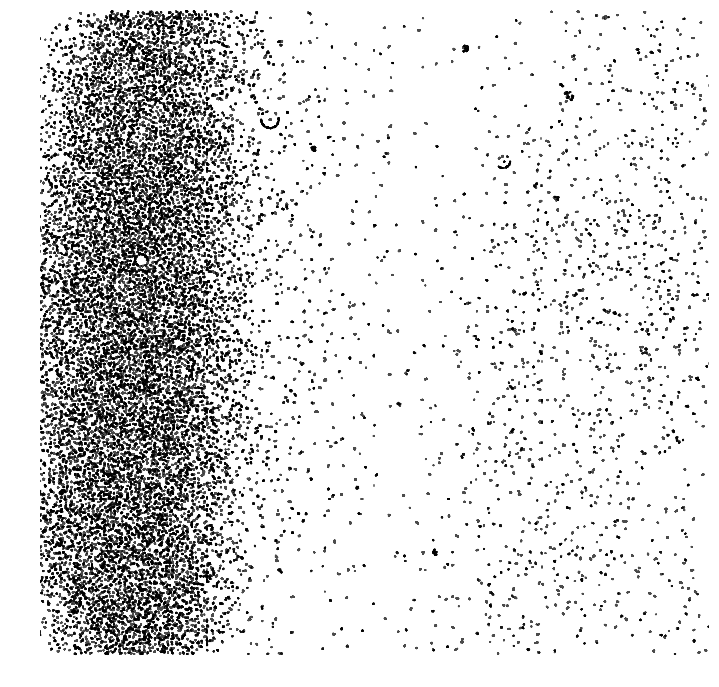

In [14]:
import diff_classifier.heatmaps as hm


hm.plot_trajectories(prefix)

Next, the user can plot heatmaps of the trajectories with colormaps scaled to a particular feature.  In this case, the heatmap is scaled to the boundedness of the trajectories.

/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:149: RuntimeWarning: invalid value encountered in less_equal
  zs = ma.masked_where(zs <= t_min, zs)
/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:150: RuntimeWarning: invalid value encountered in greater_equal
  zs = ma.masked_where(zs >= t_max, zs)


Plotted 100nm_PEG_90p_XY1 heatmap successfully.


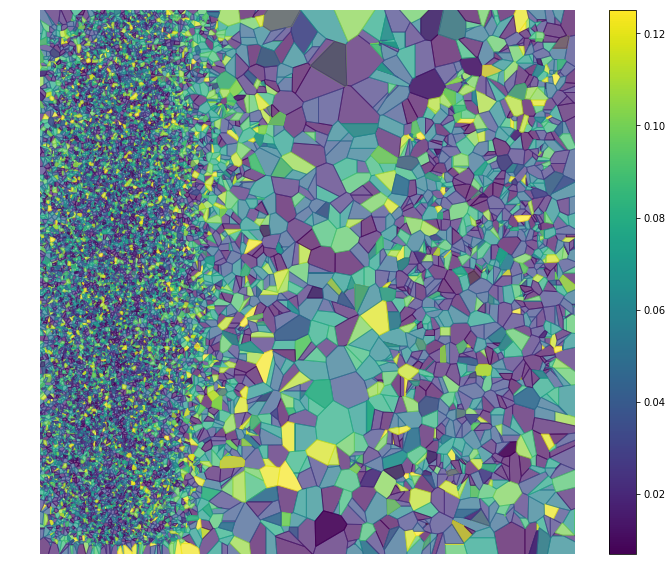

In [15]:
feature = 'boundedness'
hm.plot_heatmap(prefix, feature=feature, vmin=merged_ft[feature].quantile(0.1), vmax=merged_ft[feature].quantile(0.9))

This information can also be displayed in the form of a scatterplot:

/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:240: RuntimeWarning: invalid value encountered in less_equal
  zs = ma.masked_where(zs <= t_min, zs)
/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:241: RuntimeWarning: invalid value encountered in greater_equal
  zs = ma.masked_where(zs >= t_max, zs)


Plotted 100nm_PEG_90p_XY1 scatterplot successfully.


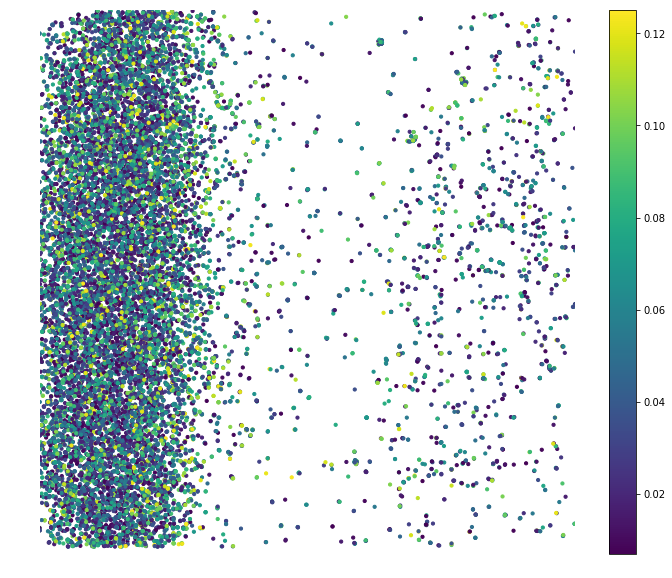

In [16]:
hm.plot_scatterplot(prefix, feature=feature, vmin=merged_ft[feature].quantile(0.1), vmax=merged_ft[feature].quantile(0.9))

The user can also plot a distribution of the diffusion coefficients:

In [17]:
hm.plot_histogram(prefix)

/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:363: RuntimeWarning: divide by zero encountered in log
  dist = np.log(umppx*umppx*merged.loc[merged.Frame == i, 'MSDs'].dropna()/factor)


ValueError: range parameter must be finite.

<Figure size 1152x432 with 0 Axes>

One useful check for data quality is the number of particles per frame.  Inevitably, this is a decreating function with respect to time lag.  However, if the linking step was performed successfully, the curve shouldn't be too steep.

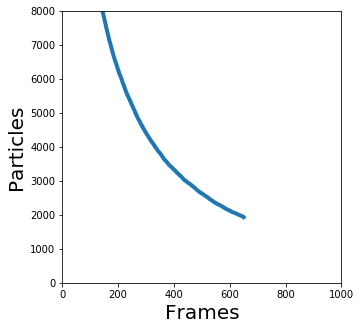

In [18]:
hm.plot_particles_in_frame(prefix, 1000, 8000)

Finally, the user can plot the MSDs of the individual trajectories.  This function also calculates the geometrically averaged MSDs and the standard deviation of the logs of the MSDs.

In [ ]:
gmean1, gSEM1 = hm.plot_individual_msds(prefix, alpha=0.05)